![SIMEM_logo_1.png](input\assets\SIMEM_logo_1.png)

<div style="text-align:center;">
  <a href="https://www.simem.co/" style="color:#002989; font-weight:bold; font-size:2em; text-decoration:none;">Ir a SiMEM</a>
</div>

# Caso de Uso 1: Predicción del Precio de Bolsa Horario (COL)
# Objetivos de este notebook

* Explicar cómo se realiza la instalación e importación de la librería pydataxm desde la consola para su uso en ambientes locales
* Explicar cómo se pueden consultar los conjuntos de datos a través de la librería Pydataxm
* Explicar cómo realizar el procesamiento y manipulación de los datos consultados
* Explicar el análisis de los datos consultados para dar respuesta al caso de uso propuesto

**Índice**

1. [Instalación de librerías](#section1)

2. [Importación de librerías](#section2)

3. [Consultar información de los conjuntos de datos](#section3)

4. [Manipulación de datos](#section4)

5. [Análisis para dar respuesta al caso de uso](#section5)

<a id='section1'></a>
# 1. Instalación de la librería
Ejecutar el siguiente comando en el CMD para instalar la librería de python.

In [40]:
# import sys
# !{sys.executable} -m pip install pydataxm

<a id='section2'></a>
# 2. Importación de librerías

In [41]:
from pydataxm.pydatasimem import ReadSIMEM          # Importa clases para interactuar con datos del sistema SIMEM, utilizado para acceder a información energética en Colombia
import pandas as pd                                 # Librería para manipulación y análisis de datos en estructuras tipo DataFrame, muy útil para limpiar, transformar y explorar datos
import matplotlib.pyplot as plt                     # Para crear gráficos estáticos como barras, líneas, histogramas, etc.
import seaborn as sns                               # Librería basada en matplotlib para visualización de datos
from dateutil.relativedelta import relativedelta    # Para trabajar con fechas y realizar operaciones de fecha
from datetime import datetime, timedelta
import datetime as dt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pydataxm.pydataxm import ReadDB
from pandas import DataFrame
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import requests
import pathlib
import time
from statsmodels.tsa.stattools import adfuller, kpss
import warnings
from statsmodels.tools.sm_exceptions import InterpolationWarning
warnings.simplefilter('ignore', InterpolationWarning)

In [42]:
###==========================
abspath = pathlib.Path.cwd()
# print(f"Directorio de trabajo: {abspath}")
###==========================

Funciones auxiliares

In [43]:
def get_periods(start_date, end_date, months_per_period):
    if isinstance(start_date, str):
        start_date = dt.datetime.strptime(start_date, '%Y-%m-%d').date()

    if isinstance(end_date, str):
        end_date = dt.datetime.strptime(end_date, '%Y-%m-%d').date()
        
    periods = []
    current_date = start_date

    while current_date <= end_date:
        # Calcular la fecha de finalización del periodo
        period_end = current_date + relativedelta(months=months_per_period) - dt.timedelta(days=1)

        # Asegurarse de que el periodo no sobrepase la fecha final
        if period_end > end_date:
            period_end = end_date

        periods.append((current_date, period_end))

        # Mover la fecha al principio del siguiente periodo
        current_date = period_end + dt.timedelta(days=1)

    return periods

<a id='section3'></a>
# 3. Consultar información de los conjuntos de datos
El método de extracción recibe los parámetros con los que se va a realizar la consulta. 
El datasetID para un conjunto particular se puede encontrar en el [catálogo de conjuntos de datos.](https://www.simem.co/pages/catalogodatos/51FC0A59-3A00-462C-B449-9CB8D5E007FB) o a través del buscador.

En este caso, la variable a consultar es el [Precio de bolsa](https://www.simem.co/datadetail/EC694552-8887-481D-8152-8055B36DB8A1).

Se definen los parámetros de entrada y se crea el objeto ReadSIMEM() para realizar las consultas.

In [44]:
def consultar_info(id_dataset, fecha_inicial, fecha_final, meses_por_periodo):
    """
    Método para extraer la información por lotes
    """
    print(rf"Consultando información para el rango: {fecha_inicial} - {fecha_final}")
    periodos = get_periods(start_date=fecha_inicial, end_date=fecha_final, months_per_period=meses_por_periodo)
    df = pd.DataFrame()
    for periodo in periodos:
        simem = ReadSIMEM(dataset_id=id_dataset, 
                          start_date=fecha_inicial, 
                          end_date=fecha_final)             # Instancia de la clase ReadSIMEM con los parámetros definidos
        _df = simem.main()                                  # Ejecución del método principal para obtener los datos en un DataFrame
        df = pd.concat([df, _df])
        time.sleep(1)

    return df
        

Extracción de datos

In [45]:
# id_dataset = 'EC6945'                                       # ID del conjunto de datos a consultar
# fecha_inicial = '2013-01-01'                                # Fecha de inicio del rango de consulta
# fecha_final = '2025-07-31'                                  # Fecha de fin del rango de consulta
# meses_por_periodo = 12
# pb_nal = consultar_info(id_dataset=id_dataset, 
#                                     fecha_inicial=fecha_inicial, 
#                                     fecha_final=fecha_final,
#                                     meses_por_periodo=meses_por_periodo)    # Ejecución del método principal para obtener los datos en un DataFrame
# pb_nal.head(5)                                                            # Visualización de las primeras 5 filas del DataFrame

In [46]:
# pb_nal: DataFrame = pb_nal[pb_nal['CodigoVariable'] == 'PB_Nal']
# pb_nal.to_csv(os.path.join('output','PB_Nal.csv'), index=False)

<a id='section4'></a>
# 4. Manipulación de datos
Los siguientes pasos corresponden a las actividades de manipulación y preparación de los datos que son relevantes para el análisis. 

In [47]:
pb_nal = pd.read_csv(os.path.join('input','PB_Nal.csv'), sep = ';')
pb_nal['FechaHora'] = pd.to_datetime(pb_nal['FechaHora'])
pb_nal = pb_nal[pb_nal['FechaHora'] >= pd.Timestamp('2020-01-01')]
# pb_nal.set_index('FechaHora', inplace=True)
pb_nal.head(5)

,CodigoVariable,FechaHora,CodigoDuracion,UnidadMedida,Version,Valor
24,PB_Nal,2020-05-31 00:00:00,PT1H,COP/kWh,TX5,221.228
25,PB_Nal,2020-05-31 01:00:00,PT1H,COP/kWh,TX5,270.143
26,PB_Nal,2020-05-31 02:00:00,PT1H,COP/kWh,TX5,221.228
27,PB_Nal,2020-05-31 03:00:00,PT1H,COP/kWh,TX5,221.228
28,PB_Nal,2020-05-31 04:00:00,PT1H,COP/kWh,TX5,221.228


In [48]:
def filtrar_ultima_version(df, columna_fecha, columna_version, columna_variable=None):          # Función para filtrar la última versión de registros por mes y variables (opcional)
    fecha_mes_col = 'año_mes'
    orden_version_col = 'orden_version'
    versiones = ['TX1', 'TX2', 'TXR', 'TXF', 'TX3', 'TX4', 'TX5', 'TX6', 'TX7', 'TX8', 'TX9', 'TX10']        # Lista de versiones ordenadas por prioridad
    version_orden = pd.Series(range(1, len(versiones) + 1), index=versiones)           # Serie que asigna un orden numérico a cada versión
    df[columna_fecha] = pd.to_datetime(df[columna_fecha])                                                   # Conversión de la columna de fecha a tipo datetime
    df[fecha_mes_col] = df[columna_fecha].dt.to_period('M')                                                     # Se crea una columna con el año y mes del registro
    df[orden_version_col] = df[columna_version].map(version_orden)                                            # Se asigna el orden de versión a cada fila

    if columna_variable is None:                                                                            # Si no se especifican variables adicionales
        df_filtrado = df.sort_values([fecha_mes_col, orden_version_col], ascending=[True, False])            # Ordena por mes y versión descendente
        df_filtrado = df_filtrado.drop_duplicates(subset=[columna_fecha], keep='first')                # Elimina duplicados conservando la última versión por fecha
    else:                                                                                                   # Si se especifican variables adicionales
        if isinstance(columna_variable, str):                                            # Convierte a lista si es un solo string
            columna_variable = [columna_variable]
        orden_columnas = columna_variable + [fecha_mes_col, orden_version_col]                                # Define el orden de columnas para ordenar
        df_filtrado = df.sort_values(orden_columnas, ascending=[True]*len(columna_variable) + [True, False])    # Ordena por variables, mes y versión
        df_filtrado = df_filtrado.drop_duplicates(subset=columna_variable + [columna_fecha], keep='first')          # Elimina duplicados por variables y fecha

    df_filtrado = df_filtrado.drop(columns=[fecha_mes_col, orden_version_col])                               # Elimina columnas auxiliares
    return df_filtrado                                                                                      # Retorna el DataFrame filtrado

In [49]:
pb_nal_filtrado = filtrar_ultima_version(df=pb_nal, columna_fecha='FechaHora', columna_version='Version', columna_variable=['CodigoVariable'])

# Validar si luego del filtrado existe algún valor duplicado
duplicados = pb_nal_filtrado.duplicated(subset=['FechaHora', 'Valor'], keep=False)
if duplicados.any():
    print("Existen duplicados por FechaHora y Valor.")
    print(pb_nal_filtrado[duplicados])
else:
    print("No existen duplicados por FechaHora y Valor.")

No existen duplicados por FechaHora y Valor.


In [50]:
# Validar si existe un valor para cada hora en el periodo del conjunto
fecha_min = pb_nal_filtrado['FechaHora'].min()
fecha_max = pb_nal_filtrado['FechaHora'].max()
rango_horas = pd.date_range(start=fecha_min, end=fecha_max, freq='H')
faltantes = set(rango_horas) - set(pd.to_datetime(pb_nal_filtrado['FechaHora']))
if faltantes:
    print(f"Faltan valores para {len(faltantes)} horas en el periodo")
else:
    print("Existe un valor para cada hora en el periodo del conjunto.")

Existe un valor para cada hora en el periodo del conjunto.


In [51]:
pb_nal_filtrado = pb_nal_filtrado.copy()[['FechaHora', 'Valor']]
pb_nal_filtrado['Valor'] = pb_nal_filtrado['Valor'].astype('float32')
pb_nal_filtrado.sort_values(by='FechaHora', inplace=True)
pb_nal_filtrado.set_index('FechaHora', inplace=True)
pb_nal_filtrado = pb_nal_filtrado.asfreq('H')
pb_nal_filtrado.head(5)

,Valor
FechaHora,
2020-01-01 00:00:00,72.016899
2020-01-01 01:00:00,136.713898
2020-01-01 02:00:00,127.713898
2020-01-01 03:00:00,127.713898
2020-01-01 04:00:00,127.713898


<a id='section5'></a>
# 5. Análisis para dar respuesta al caso de uso

### Pronóstico del Precio de Bolsa Nacional

En esta sección se realizará el análisis de la serie de tiempo y se probarán diferentes modelos de pronóstico:

- Análisis exploratorio y estadístico de la serie
- Validación de estacionariedad
- Modelo SARIMAX
- Modelo XGBoost
- Comparación de resultados

Se utilizarán métricas como MAE y RMSE para comparar el desempeño de cada modelo.

## Análisis exploratorio y estadístico de la serie

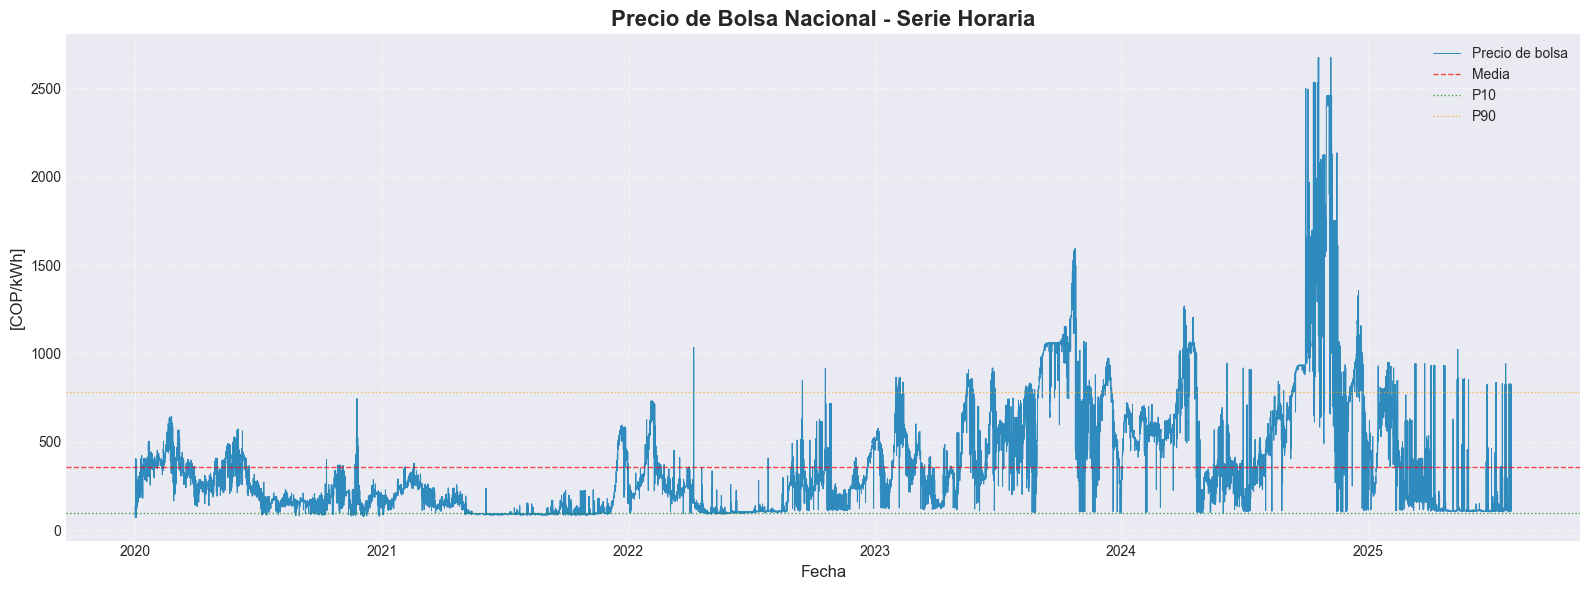

In [52]:
plt.figure(figsize=(16,6))
plt.plot(pb_nal_filtrado['Valor'], color='#0072B2', linewidth=0.7, alpha=0.8, label='Precio de bolsa')
plt.title('Precio de Bolsa Nacional - Serie Horaria', fontsize=16, fontweight='bold')
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('[COP/kWh]', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.legend()

# Resumen visual: media y percentiles
media = pb_nal_filtrado['Valor'].mean()
p10 = pb_nal_filtrado['Valor'].quantile(0.10)
p90 = pb_nal_filtrado['Valor'].quantile(0.90)
plt.axhline(media, color='red', linestyle='--', linewidth=1, alpha=0.7, label='Media')
plt.axhline(p10, color='green', linestyle=':', linewidth=1, alpha=0.7, label='P10')
plt.axhline(p90, color='orange', linestyle=':', linewidth=1, alpha=0.7, label='P90')
plt.legend()
plt.show()

## Validación de estacionariedad

**¿Para qué sirven las pruebas de estacionariedad ADF y KPSS?**
- Estas pruebas permiten determinar si una serie de tiempo es estacionaria, es decir, si sus propiedades estadísticas (media, varianza) se mantienen constantes a lo largo del tiempo.
- La estacionariedad es fundamental para aplicar modelos clásicos de pronóstico como ARIMA/SARIMA, ya que estos modelos asumen que la serie no tiene tendencias ni cambios estructurales.
- Si la serie no es estacionaria, se deben aplicar transformaciones (como la diferenciación) antes de modelar.

Las pruebas de estacionariedad son el primer paso para validar si podemos aplicar modelos de pronóstico confiables. Si la serie es estacionaria, avanzamos; si no, la transformamos y volvemos a probar.

In [53]:
# Validación de estacionariedad
result_adf = adfuller(pb_nal_filtrado['Valor'])
print('ADF Statistic:', result_adf[0])
print('p-value:', result_adf[1])
if result_adf[1] < 0.05:
    print('La serie es estacionaria según ADF.')
else:
    print('La serie NO es estacionaria según ADF.')
print("*****************")
result_kpss = kpss(pb_nal_filtrado['Valor'], regression='c')
print('KPSS Statistic:', result_kpss[0])
print('p-value:', result_kpss[1])
if result_kpss[1] < 0.05:
    print('La serie NO es estacionaria según KPSS.')
else:
    print('La serie es estacionaria según KPSS.')

ADF Statistic: -5.079444590409134
p-value: 1.5416414515396877e-05
La serie es estacionaria según ADF.
*****************
KPSS Statistic: 8.76110684731554
p-value: 0.01
La serie NO es estacionaria según KPSS.


**Interpretación de las pruebas de estacionariedad (serie original):**
- Si el p-valor de ADF es menor a 0.05, la serie es estacionaria según ADF.
- Si el p-valor de KPSS es mayor a 0.05, la serie es estacionaria según KPSS.
- Si ambas pruebas indican estacionariedad, la serie está lista para modelado ARIMA/SARIMA.
- Si alguna prueba indica no estacionariedad, se recomienda diferenciar la serie y repetir las pruebas.

In [54]:
# Diferenciación de la serie y nueva validación de estacionariedad
pb_nal_diff = pb_nal_filtrado['Valor'].diff().dropna()
print('Pruebas de estacionariedad sobre la serie diferenciada')
result_adf_diff = adfuller(pb_nal_diff)
print('ADF Statistic (diferenciada):', result_adf_diff[0])
print('p-value (diferenciada):', result_adf_diff[1])
if result_adf_diff[1] < 0.05:
    print('La serie diferenciada es estacionaria según ADF.')
else:
    print('La serie diferenciada NO es estacionaria según ADF.')

print("*****************")

result_kpss_diff = kpss(pb_nal_diff, regression='c')
print('KPSS Statistic (diferenciada):', result_kpss_diff[0])
print('p-value (diferenciada):', result_kpss_diff[1])
if result_kpss_diff[1] < 0.05:
    print('La serie diferenciada NO es estacionaria según KPSS.')
else:
    print('La serie diferenciada es estacionaria según KPSS.')

Pruebas de estacionariedad sobre la serie diferenciada
ADF Statistic (diferenciada): -35.21196338066464
p-value (diferenciada): 0.0
La serie diferenciada es estacionaria según ADF.
*****************
KPSS Statistic (diferenciada): 0.019473477009176277
p-value (diferenciada): 0.1
La serie diferenciada es estacionaria según KPSS.


**Interpretación de las pruebas de estacionariedad sobre la serie diferenciada:**
- Si el p-valor de ADF es menor a 0.05, la serie diferenciada es estacionaria según ADF.
- Si el p-valor de KPSS es mayor a 0.05, la serie diferenciada es estacionaria según KPSS.
- Si ambas pruebas indican estacionariedad, la serie está lista para modelado ARIMA/SARIMA.
- Si alguna prueba aún indica no estacionariedad, puede ser necesario aplicar una segunda diferenciación o revisar la serie por tendencias o cambios estructurales.

## Modelo SARIMAX

### ¿Cómo ajustar los parámetros SARIMAX (p,d,q,P,D,Q,s)?
- **ACF/PACF:** Las funciones de autocorrelación (ACF) y autocorrelación parcial (PACF) ayudan a identificar los valores óptimos de p, q (autorregresivo y media móvil) y sus equivalentes estacionales (P, Q).
- **Grid Search:** Puedes automatizar la búsqueda probando varias combinaciones de parámetros y seleccionando la que minimice el error (MAE, RMSE).
- **Pasos recomendados:**
    1. Visualiza ACF y PACF para estimar p, q, P, Q.
    2. Ajusta d y D según las pruebas de estacionariedad.
    3. Usa grid search para encontrar la mejor combinación.

A continuación se muestra cómo visualizar ACF y PACF.

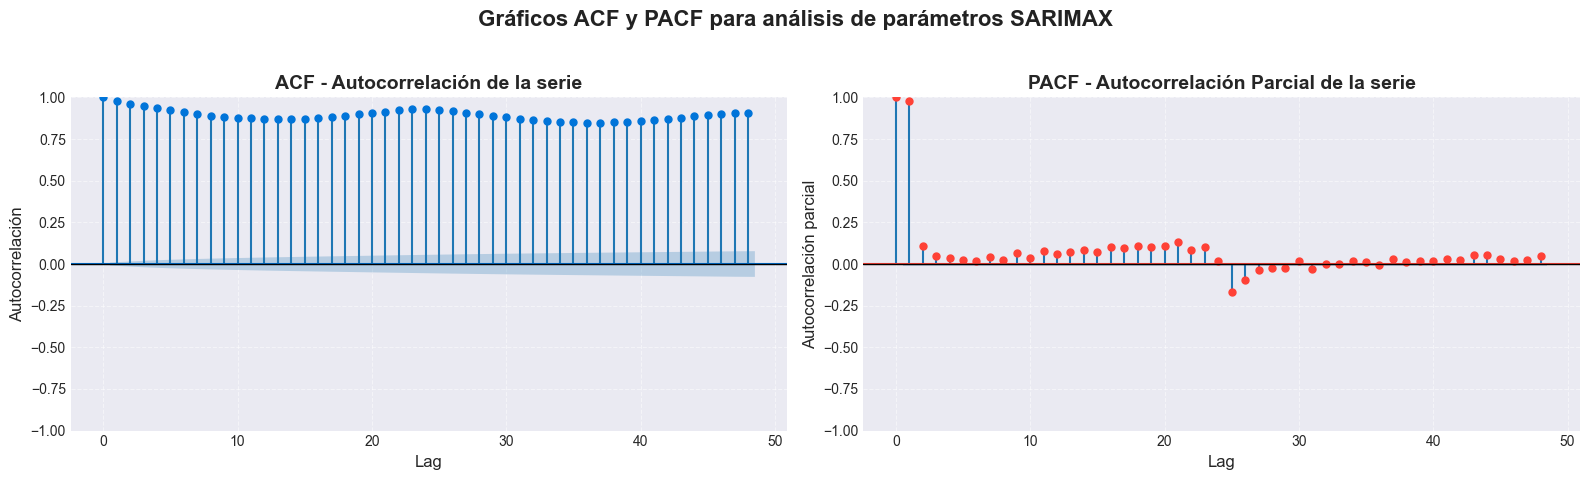

In [55]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axes = plt.subplots(1, 2, figsize=(16,5))
plot_acf(pb_nal_filtrado['Valor'], lags=48, ax=axes[0], color='#0074D9')
axes[0].set_title('ACF - Autocorrelación de la serie', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Lag', fontsize=12)
axes[0].set_ylabel('Autocorrelación', fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.5)
axes[0].axhline(0, color='black', linewidth=1)
plot_pacf(pb_nal_filtrado['Valor'], lags=48, ax=axes[1], color='#FF4136')
axes[1].set_title('PACF - Autocorrelación Parcial de la serie', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Lag', fontsize=12)
axes[1].set_ylabel('Autocorrelación parcial', fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.5)
axes[1].axhline(0, color='black', linewidth=1)
plt.suptitle('Gráficos ACF y PACF para análisis de parámetros SARIMAX', fontsize=16, fontweight='bold', color='#222')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**Interpretación ACF/PACF y su relación con SARIMAX:**
- Si la ACF muestra decaimiento lento y la PACF tiene un corte abrupto tras el primer o segundo lag, la serie sugiere un modelo AR (p > 0, q = 0).
- Si la PACF decae lentamente y la ACF tiene un corte abrupto, la serie sugiere un modelo MA (p = 0, q > 0).
- Si ambos decaen lentamente, puede requerir diferenciación (d > 0).
- Los patrones estacionales en los gráficos (por ejemplo, picos cada 24 lags) sugieren incluir componentes estacionales (P, Q, D, s).
- En la práctica, los valores de p y q se eligen según el número de lags significativos en PACF y ACF, respectivamente.
- Estos valores se traducen directamente en los argumentos `order=(p,d,q)` y `seasonal_order=(P,D,Q,s)` del modelo SARIMAX.

### **Ejemplo de Grid Search para SARIMAX**
Puedes automatizar la búsqueda de parámetros probando varias combinaciones y seleccionando la que minimice el error (por ejemplo, MAE o RMSE).
A continuación se muestra un ejemplo básico de grid search para SARIMAX.

In [56]:
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
best_mae = float('inf')
best_params = None
p =[0,1]
d =[1]
q =[0]
P =[0,1]
D =[1]
Q =[0]
s = 24  # estacionalidad diaria para datos horarios
for param in itertools.product(p, d, q):
    for param_seasonal in itertools.product(P, D, Q):
        try:
            model = SARIMAX(pb_nal_filtrado['Valor'],
                            order=param,
                            seasonal_order=param_seasonal + (s,))
            results = model.fit(disp=False)
            forecast = results.get_forecast(steps=24)
            y_true = pb_nal_filtrado['Valor'][-24:]
            y_pred = forecast.predicted_mean
            mae = mean_absolute_error(y_true, y_pred)
            if mae < best_mae:
                best_mae = mae
                best_params = (param, param_seasonal)
            print(f"SARIMAX{param}x{param_seasonal + (s,)} - MAE: {mae:.2f}")
        except Exception as e:
            print(f"Error con SARIMAX{param}x{param_seasonal + (s,)}: {e}")
print(f"Mejores parámetros: {best_params}, MAE: {best_mae:.2f}")

SARIMAX(0, 1, 0)x(0, 1, 0, 24) - MAE: 4.97
SARIMAX(0, 1, 0)x(1, 1, 0, 24) - MAE: 3.31
SARIMAX(1, 1, 0)x(0, 1, 0, 24) - MAE: 1.40
SARIMAX(1, 1, 0)x(1, 1, 0, 24) - MAE: 3.37
Mejores parámetros: ((1, 1, 0), (0, 1, 0)), MAE: 1.40


In [57]:
# Registrar automáticamente los mejores parámetros SARIMAX y valores relevantes de ACF/PACF
from statsmodels.tsa.stattools import acf, pacf
import numpy as np
# Calcular ACF y PACF hasta lag 48
acf_vals = acf(pb_nal_filtrado['Valor'], nlags=48)
pacf_vals = pacf(pb_nal_filtrado['Valor'], nlags=48)
# Encontrar lags significativos (mayores a 2*desviación estándar)
# acf_sig = np.where(np.abs(acf_vals) > 0.8)[0]
pacf_sig = np.where(np.abs(pacf_vals) > 0.8)[0]
# print('Lags significativos en ACF:', acf_sig)
print('Lags significativos en PACF:', pacf_sig)
if 'best_params' in locals():
    print('Mejores parámetros SARIMAX encontrados por grid search:')
    print('order:', best_params[0])
    print('seasonal_order:', best_params[1] + (s,))
    print('MAE óptimo:', best_mae)
else:
    print('Ejecuta primero la celda de grid search para obtener los mejores parámetros.')

Lags significativos en PACF: [0 1]
Mejores parámetros SARIMAX encontrados por grid search:
order: (1, 1, 0)
seasonal_order: (0, 1, 0, 24)
MAE óptimo: 1.3989496958464163


In [58]:
# Asignar valores independientes para p y d
p = 1  # valor autorregresivo (puedes cambiarlo)
d = 1  # grado de diferenciación (puedes cambiarlo)
q = 0  # valor por defecto para media móvil
P = 0  # valor por defecto para componente estacional autorregresivo
D = 1  # valor por defecto para diferenciación estacional
Q = 0  # valor por defecto para componente estacional media móvil
s = 24 # estacionalidad diaria para datos horarios
print(f"Parámetros asignados: p={p}, d={d}, q={q}, P={P}, D={D}, Q={Q}, s={s}")
model = SARIMAX(pb_nal_filtrado['Valor'], order=(p,d,q), seasonal_order=(P,D,Q,s))
results = model.fit()
print(results.summary())

Parámetros asignados: p=1, d=1, q=0, P=0, D=1, Q=0, s=24
                                     SARIMAX Results                                      
Dep. Variable:                              Valor   No. Observations:                48936
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 24)   Log Likelihood             -284475.125
Date:                           jue, 28 ago. 2025   AIC                         568954.251
Time:                                    10:58:13   BIC                         568971.846
Sample:                                01-01-2020   HQIC                        568959.768
                                     - 07-31-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2544      0.001   -286.415      0.000   

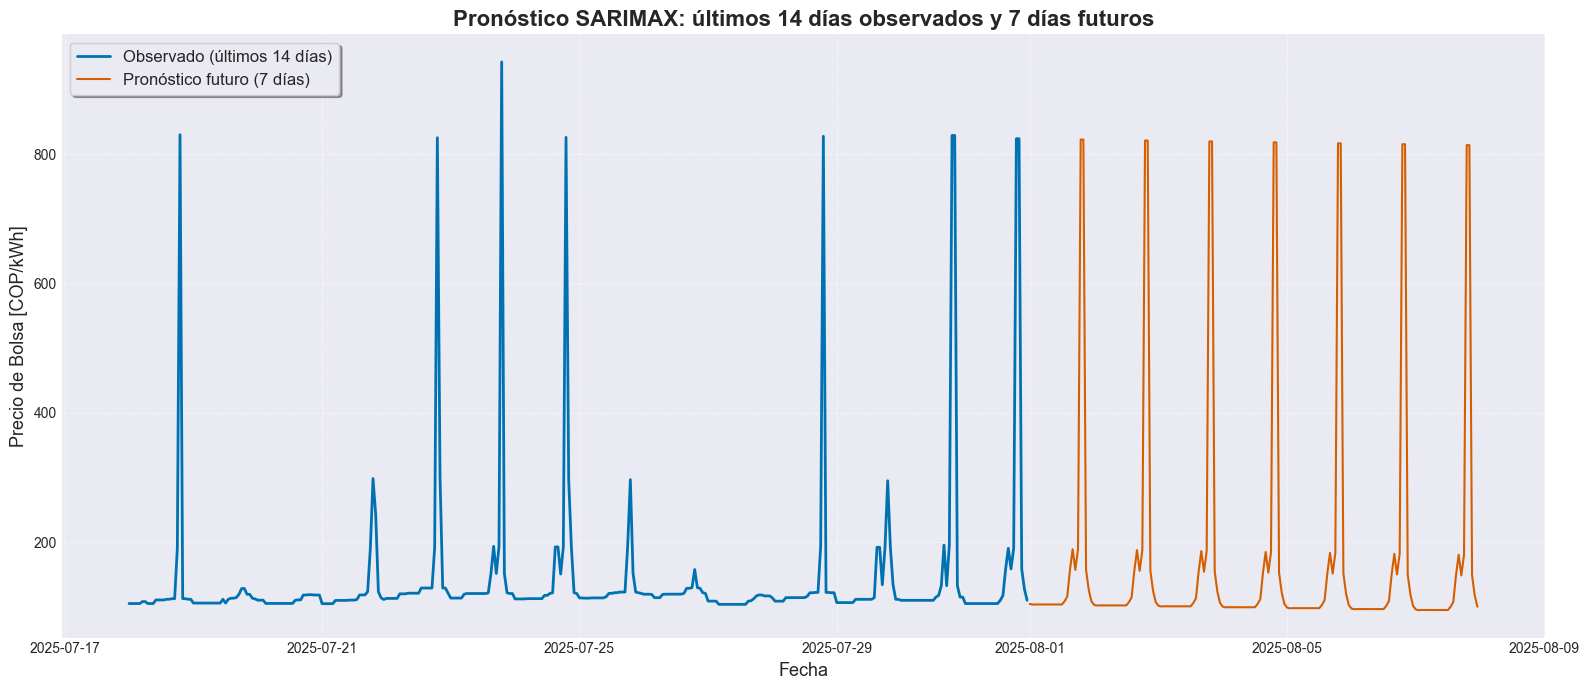

In [59]:
# Pronóstico: solo últimos 14 días observados y 7 días pronosticados
dias_obs = 14
dias_pred = 7
horas_obs = 24 * dias_obs
horas_pred = 24 * dias_pred

forecast = results.get_forecast(steps=horas_pred)
pred_ci = forecast.conf_int()

# Seleccionar los últimos 14 días observados
observados = pb_nal_filtrado['Valor'][-horas_obs:]

# Fechas para el pronóstico
fechas_pred = pd.date_range(pb_nal_filtrado.index[-1], periods=horas_pred+1, freq='H')[1:]

plt.figure(figsize=(16,7))
plt.style.use('seaborn-v0_8-darkgrid')
plt.plot(observados.index, observados, label='Observado (últimos 14 días)', color='#0072B2', linewidth=2)
plt.plot(fechas_pred, forecast.predicted_mean, label='Pronóstico futuro (7 días)', color='#D55E00')#, linestyle='-', linewidth=2, marker='x', markersize=5)
# plt.fill_between(fechas_pred, pred_ci['lower Valor'], pred_ci['upper Valor'], color='#D55E00', alpha=0.15, label='Intervalo de confianza')
plt.title('Pronóstico SARIMAX: últimos 14 días observados y 7 días futuros', fontsize=16, fontweight='bold')
plt.xlabel('Fecha', fontsize=13)
plt.ylabel('Precio de Bolsa [COP/kWh]', fontsize=13)
plt.legend(fontsize=12, loc='upper left', frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.gcf().set_facecolor('white')
plt.show()

**Ejemplos visuales y recomendaciones para elegir parámetros SARIMAX:**
- Si en el gráfico PACF el primer lag es significativo y los siguientes no, prueba p=1.
- Si en el gráfico ACF el primer lag es significativo y los siguientes no, prueba q=1.
- Si ambos gráficos muestran decaimiento lento, prueba d=1 (diferenciación).
- Si ves picos regulares cada 24 lags (por ejemplo, datos horarios con estacionalidad diaria), prueba P=1, Q=1, D=1, s=24.
- Si los gráficos muestran varios lags significativos, puedes probar valores mayores para p, q, P, Q.
- Siempre valida el modelo con métricas como MAE y RMSE y ajusta los parámetros según el desempeño.
- Usa grid search para automatizar la búsqueda de la mejor combinación de parámetros.

**Métricas MAE y RMSE:**
- **MAE (Mean Absolute Error):** Indica el promedio de los errores absolutos entre los valores reales y los predichos. Un MAE bajo significa que el modelo predice valores cercanos a los observados.
- **RMSE (Root Mean Squared Error):** Es similar al MAE pero penaliza más los errores grandes. Un RMSE bajo indica buena precisión y pocos errores grandes.
- **Visualización:** Además de las métricas, revisa los gráficos de predicción vs. realidad para asegurarte que el modelo captura bien los patrones.

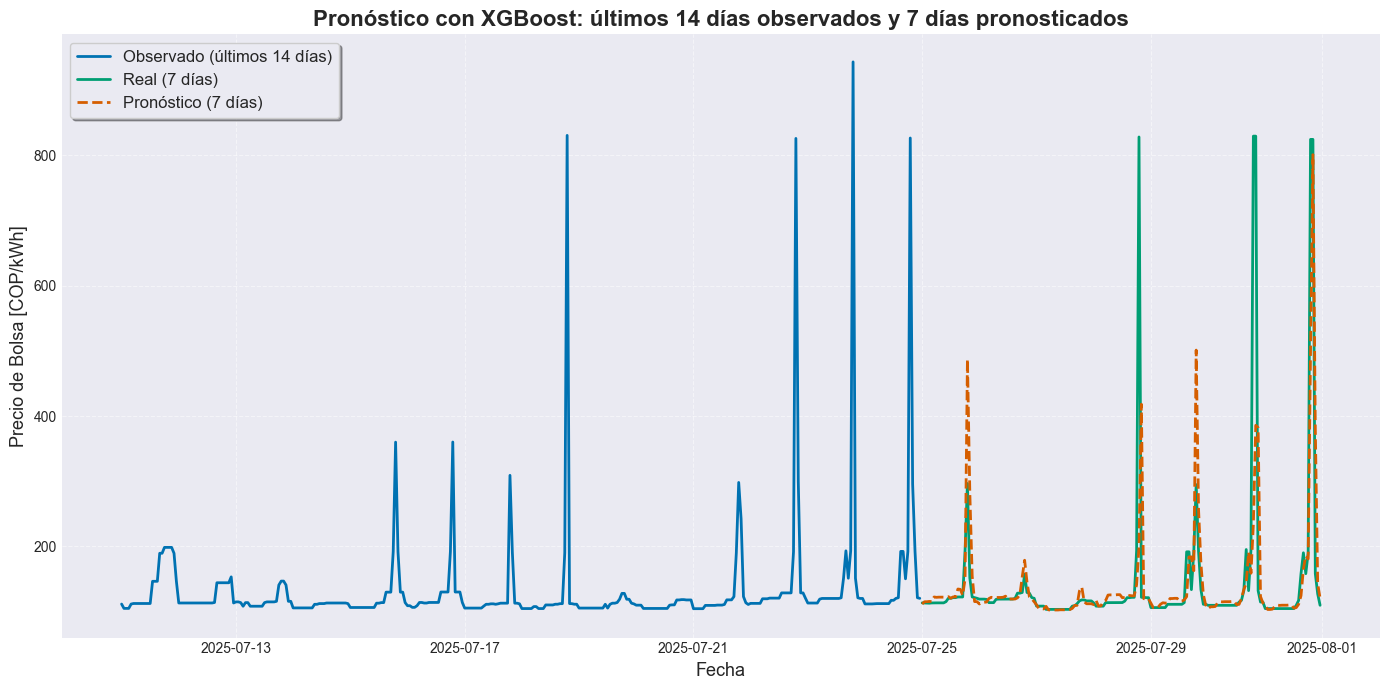

MAE: 27.674266815185547
RMSE: 8237.87109375


In [60]:
# Prueba de modelo XGBoost para series de tiempo
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb

# Preparar datos para XGBoost
df_xgb = pb_nal_filtrado.copy()
df_xgb['hour'] = df_xgb.index.hour
df_xgb['dayofweek'] = df_xgb.index.dayofweek
df_xgb['month'] = df_xgb.index.month
df_xgb['lag1'] = df_xgb['Valor'].shift(1)
df_xgb['lag24'] = df_xgb['Valor'].shift(24)
df_xgb = df_xgb.dropna()

X = df_xgb[['hour','dayofweek','month','lag1','lag24']]
y = df_xgb['Valor']

# Entrenamiento con toda la data excepto los últimos 7 días
horas_pred = 24 * 7
X_train = X.iloc[:-horas_pred]
y_train = y.iloc[:-horas_pred]
X_test = X.iloc[-horas_pred:]
y_test = y.iloc[-horas_pred:]

model_xgb = xgb.XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1)
model_xgb.fit(X_train, y_train)
y_pred = model_xgb.predict(X_test)

# Para graficar los últimos 14 días observados y los 7 días pronosticados
horas_obs = 24 * 14
y_obs = y.iloc[-(horas_obs + horas_pred):-horas_pred]
fechas_obs = y_obs.index
fechas_pred = y_test.index

plt.figure(figsize=(14,7))
plt.style.use('seaborn-v0_8-darkgrid')
plt.plot(fechas_obs, y_obs, label='Observado (últimos 14 días)', color='#0072B2', linewidth=2)
plt.plot(fechas_pred, y_test, label='Real (7 días)', color='#009E73', linewidth=2)#, marker='o', markersize=4)
plt.plot(fechas_pred, y_pred, label='Pronóstico (7 días)', color='#D55E00', linestyle='--', linewidth=2)#, marker='x', markersize=5)
plt.title('Pronóstico con XGBoost: últimos 14 días observados y 7 días pronosticados', fontsize=16, fontweight='bold')
plt.xlabel('Fecha', fontsize=13)
plt.ylabel('Precio de Bolsa [COP/kWh]', fontsize=13)
plt.legend(fontsize=12, loc='upper left', frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.gcf().set_facecolor('white')
plt.show()

print('MAE:', mean_absolute_error(y_test, y_pred))
print('RMSE:', mean_squared_error(y_test, y_pred))

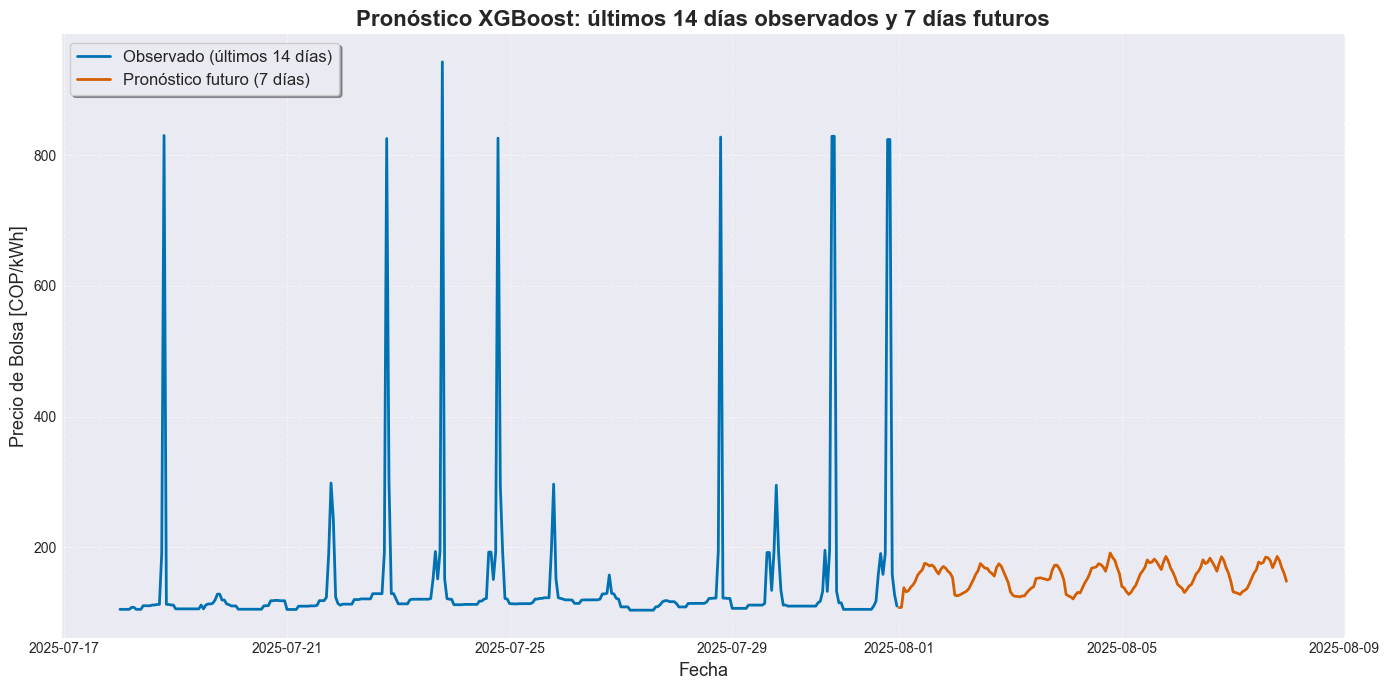

Fechas pronosticadas: 2025-08-01 00:00:00 a 2025-08-07 23:00:00


In [61]:
# Entrenamiento XGBoost para pronóstico de 7 días futuros
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Preparar datos para XGBoost (usar todos los datos disponibles)
df_xgb_fut = pb_nal_filtrado.copy()
df_xgb_fut['hour'] = df_xgb_fut.index.hour
df_xgb_fut['dayofweek'] = df_xgb_fut.index.dayofweek
df_xgb_fut['month'] = df_xgb_fut.index.month
df_xgb_fut['lag1'] = df_xgb_fut['Valor'].shift(1)
df_xgb_fut['lag24'] = df_xgb_fut['Valor'].shift(24)
df_xgb_fut = df_xgb_fut.dropna()

X_fut = df_xgb_fut[['hour','dayofweek','month','lag1','lag24']]
y_fut = df_xgb_fut['Valor']

# Entrenar el modelo con todos los datos históricos
model_xgb_fut = xgb.XGBRegressor(n_estimators=100, max_depth=10, learning_rate=0.1)
model_xgb_fut.fit(X_fut, y_fut)

# Pronóstico recursivo de 7 días futuros (168 horas)
n_futuro = 24 * 7
last_index = df_xgb_fut.index[-1]
future_dates = pd.date_range(start=last_index + pd.Timedelta(hours=1), periods=n_futuro, freq='H')

future_preds = []
lag1 = df_xgb_fut['Valor'][-1]
lag24 = df_xgb_fut['Valor'][-24] if len(df_xgb_fut) >= 24 else lag1

for i, fecha in enumerate(future_dates):
    features = {
        'hour': fecha.hour,
        'dayofweek': fecha.dayofweek,
        'month': fecha.month,
        'lag1': lag1,
        'lag24': lag24
    }
    X_pred = pd.DataFrame([features])
    pred = model_xgb_fut.predict(X_pred)[0]
    future_preds.append(pred)
    lag24 = lag1 if i < 23 else future_preds[i-23]
    lag1 = pred

# Graficar últimos 14 días observados y los 7 días futuros pronosticados
horas_obs = 24 * 14
y_obs = y_fut.iloc[-horas_obs:]
fechas_obs = y_obs.index

plt.figure(figsize=(14,7))
plt.style.use('seaborn-v0_8-darkgrid')
plt.plot(fechas_obs, y_obs, label='Observado (últimos 14 días)', color='#0072B2', linewidth=2)
plt.plot(future_dates, future_preds, label='Pronóstico futuro (7 días)', color='#D55E00', linestyle='-', linewidth=2)#, marker='x', markersize=5)
plt.title('Pronóstico XGBoost: últimos 14 días observados y 7 días futuros', fontsize=16, fontweight='bold')
plt.xlabel('Fecha', fontsize=13)
plt.ylabel('Precio de Bolsa [COP/kWh]', fontsize=13)
plt.legend(fontsize=12, loc='upper left', frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.gcf().set_facecolor('white')
plt.show()

print('Fechas pronosticadas:', future_dates[0], 'a', future_dates[-1])

In [62]:
# Comparación de resultados de los modelos
print('Comparación de modelos:')
print('SARIMAX:')
print('MAE:', results.mae if hasattr(results, 'mae') else 'Calcular manualmente')
print('RMSE:', results.mse if hasattr(results, 'mse') else 'Calcular manualmente')

print('XGBoost:')
print('MAE:', mean_absolute_error(y_test, y_pred))
print('RMSE:', mean_squared_error(y_test, y_pred))

Comparación de modelos:
SARIMAX:
MAE: 26.806083777614976
RMSE: 6597.124471363182
XGBoost:
MAE: 27.674266815185547
RMSE: 8237.87109375
